In [1]:
import pandas as pd
import numpy as np

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb

# Optuna for hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/ckasemtantikul/Downloads/wvs-2018-china-data.csv')
df = df[~df.lt(0).any(axis=1)]
df = df.reset_index()
df = df.dropna()

In [3]:
# Q 260: Sex 1 = male, 2 = female
# Q 262: Age
# Q 275: 0 = no education, 1 = primary, 2 = secondary, 3 = high school, 4 = university, 5 = master, 6 = PhD
# Q 71: what is your feeling about china communist party: 1 = high trust, 2 = trust, 3 = not really trusting, 4 = no trust at all
# Q 115: the amount of people in government: 1 = no people, 2 = vert few people, 3 = a lot of people, 4 = all of people
# Q 113: the amount of people in the communist party in china: 1 = no people, 2 = vert few people, 3 = a lot of people, 4 = all of people
# Q 199: how interested are you in politics: 1 = very interested, 2 = a little bit of interest, 3 = not really interested, 4 = no interest at all
# Q 251: how democratic is china: 1 to 10 where 1 means least and 10 means most
# Q 33: during time of unemployment, men should have more work authority than women: 1 highly agreed, 2 = agreed, 3 = don't know, 3 = not agreeed, 4 = highly not agreed

In [4]:
# Map gender to binary values
df['Age'] = df['Q262'].astype(int)
df['Gender'] = df['Q260'].map({1: 0, 2: 1})

# Map education levels (already numerical, but ensure it's treated as categorical if necessary)
df['Education'] = df['Q275'].astype(int)

df['Interest_Politics'] = df['Q199'].astype(int)
df['China_Democracy_Perception'] = df['Q251'].astype(int)
df['Attitude_Gender_Role'] = df['Q33'].astype(int)
df['Perception_Gov_Size'] = df['Q115'].astype(int)
df['Perception_CCP_Size'] = df['Q113'].astype(int)

# Map Trust Level to numerical values (ensure it's continuous)
trust_mapping = {
    1: 3,  # High trust
    2: 2,  # Trust
    3: 1,  # Not really trusting
    4: 0   # No trust at all
}
df['Trust_Level'] = df['Q71'].map(trust_mapping).astype(int)
df['Interest_Politics'] = df['Interest_Politics'].map(trust_mapping).astype(float)
df['Attitude_Gender_Role'] = df['Attitude_Gender_Role'].map(trust_mapping).astype(float)

In [5]:
# Features to include
features = [
    'Gender',                
    'Age',                   
    'Education',             
    'Interest_Politics',                  
    'China_Democracy_Perception',                  
    'Attitude_Gender_Role',                   
    'Perception_Gov_Size', 
    'Perception_CCP_Size'                 
    # Add more features as needed
]

# Ensure all features are in the DataFrame
df = df[features + ['Trust_Level']]

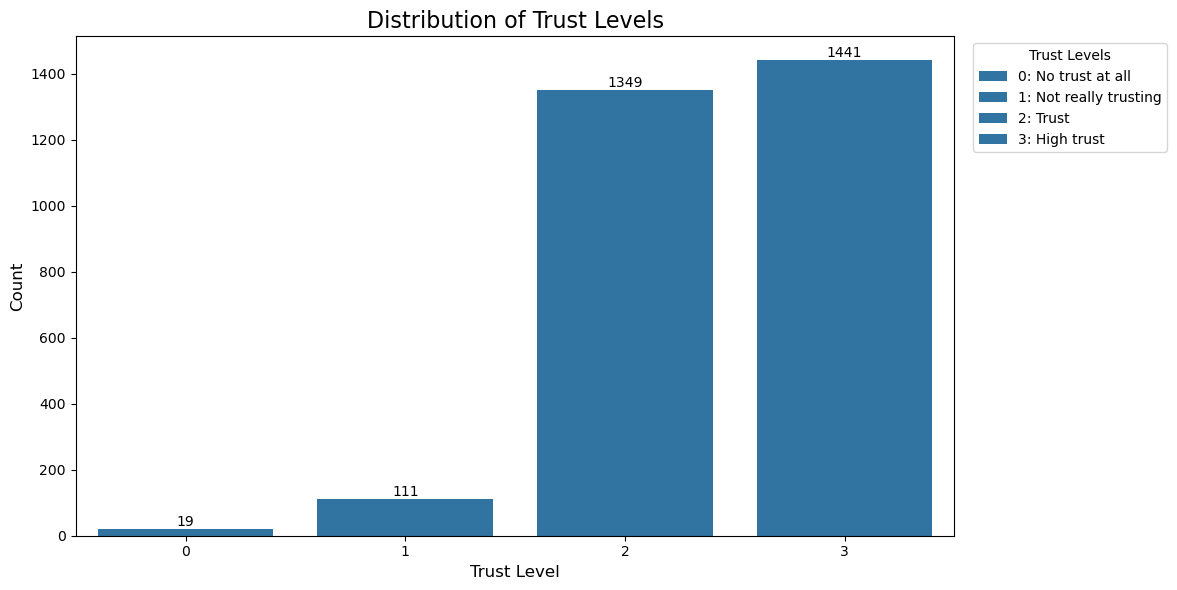

In [6]:
import seaborn as sns

# Count the occurrences of each Trust level
trust_counts = df['Trust_Level'].value_counts().sort_index()

# Create a dictionary for the legend
trust_legend = {
    0: 'No trust at all',
    1: 'Not really trusting',
    2: 'Trust',
    3: 'High trust'
}

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=trust_counts.index, y=trust_counts.values)

# Customize the plot
plt.title('Distribution of Trust Levels', fontsize=16)
plt.xlabel('Trust Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels on top of each bar
for i, v in enumerate(trust_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add legend
legend_labels = [f"{k}: {v}" for k, v in trust_legend.items()]
plt.legend(bars.patches, legend_labels, title="Trust Levels", loc="upper right", bbox_to_anchor=(1.25, 1))

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['Trust_Level']

# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def objective(trial):
    # Define hyperparameter space
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',  # For multiclass classification
        'num_class': len(np.unique(y)),
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',  # Use 'gpu_hist' if you have a GPU
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-5, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
    }
    
    model = xgb.XGBClassifier(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return 1.0 - accuracy

In [9]:
# Create a study object and specify the direction as 'minimize'
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Start the optimization
study.optimize(objective, n_trials=500, timeout=3600)

# Get the best trial
print("Best trial:")
trial = study.best_trial

print("  Value (1 - accuracy): {:.4f}".format(trial.value))
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-18 13:16:37,257] A new study created in memory with name: no-name-19c9a24f-2d36-4866-99f6-9356885a10f9
[I 2024-10-18 13:16:37,396] Trial 0 finished with value: 0.43493150684931503 and parameters: {'lambda': 0.0017670169402947942, 'alpha': 5.0615768887523, 'colsample_bytree': 0.8659969709057025, 'subsample': 0.7993292420985183, 'learning_rate': 0.055245405728306586, 'n_estimators': 240, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 3.005575058716044}. Best is trial 0 with value: 0.43493150684931503.
[I 2024-10-18 13:16:37,555] Trial 1 finished with value: 0.44006849315068497 and parameters: {'lambda': 0.17718847354806802, 'alpha': 1.3289448722869181e-05, 'colsample_bytree': 0.9849549260809971, 'subsample': 0.9162213204002109, 'learning_rate': 0.07157834209670008, 'n_estimators': 263, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 0 with value: 0.43493150684931503.
[I 2024-10-18 13:16:37,825] Trial 2 finished with value: 0.4332191780821918

Best trial:
  Value (1 - accuracy): 0.3904
  Best hyperparameters:
    lambda: 0.0005595123242289741
    alpha: 4.62522393445393e-05
    colsample_bytree: 0.7999733624316165
    subsample: 0.5001257993575619
    learning_rate: 0.23086975618173455
    n_estimators: 549
    max_depth: 5
    min_child_weight: 3
    gamma: 3.1432208779758355


In [10]:
print("Best trial:")
trial = study.best_trial

print("  Value (1 - accuracy): {:.4f}".format(trial.value))
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 4. Update Parameters and Train Final Model
best_params = trial.params
best_params.update({
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'random_state': 42,
})

model = xgb.XGBClassifier(**best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

Best trial:
  Value (1 - accuracy): 0.4007
  Best hyperparameters:
    lambda: 5.985571125484311
    alpha: 0.024303890011352056
    colsample_bytree: 0.943318217486047
    subsample: 0.20728769885208811
    learning_rate: 0.43517780490393654
    n_estimators: 288
    max_depth: 11
    min_child_weight: 6
    gamma: 2.1795307392120273
[0]	validation_0-mlogloss:1.17387
[1]	validation_0-mlogloss:1.03420
[2]	validation_0-mlogloss:0.96038
[3]	validation_0-mlogloss:0.91175
[4]	validation_0-mlogloss:0.87856
[5]	validation_0-mlogloss:0.85219
[6]	validation_0-mlogloss:0.83244
[7]	validation_0-mlogloss:0.81752
[8]	validation_0-mlogloss:0.80831
[9]	validation_0-mlogloss:0.79934
[10]	validation_0-mlogloss:0.79294
[11]	validation_0-mlogloss:0.79023
[12]	validation_0-mlogloss:0.78691
[13]	validation_0-mlogloss:0.78354
[14]	validation_0-mlogloss:0.78117
[15]	validation_0-mlogloss:0.77667
[16]	validation_0-mlogloss:0.77632
[17]	validation_0-mlogloss:0.77595
[18]	validation_0-mlogloss:0.77521
[19]	val

XGBClassifier(alpha=0.024303890011352056, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.943318217486047, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=2.1795307392120273, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=5.985571125484311,
              learning_rate=0.43517780490393654, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=288, n_jobs=None, ...)


Test Accuracy: 60.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        13
           2       0.59      0.59      0.59       273
           3       0.63      0.66      0.64       296

    accuracy                           0.61       584
   macro avg       0.30      0.31      0.31       584
weighted avg       0.59      0.61      0.60       584



/opt/anaconda3/envs/MapleLab/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MapleLab/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/MapleLab/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

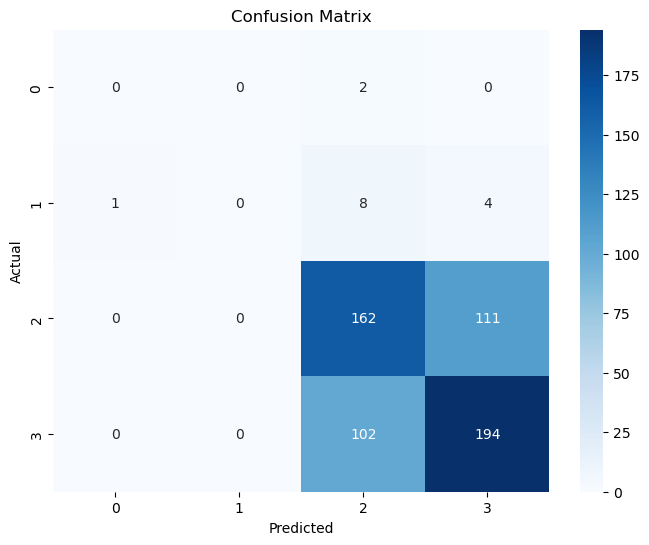

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict on the test set
preds = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, preds)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, preds)
class_names = np.unique(y)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

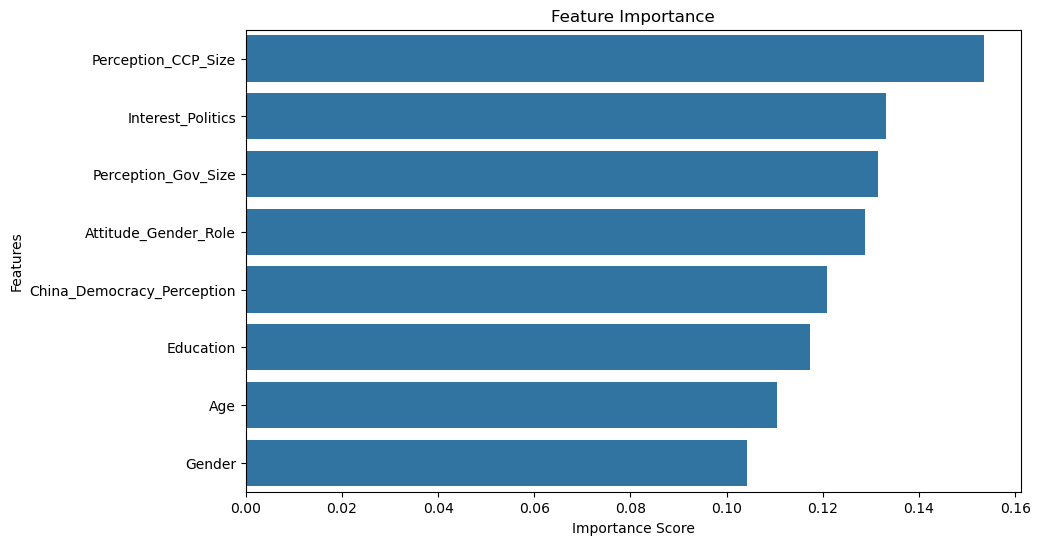

In [66]:
# Get feature importance
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

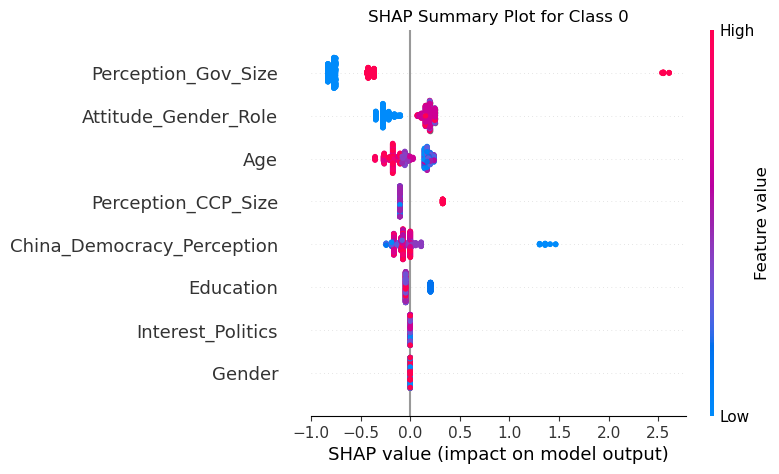

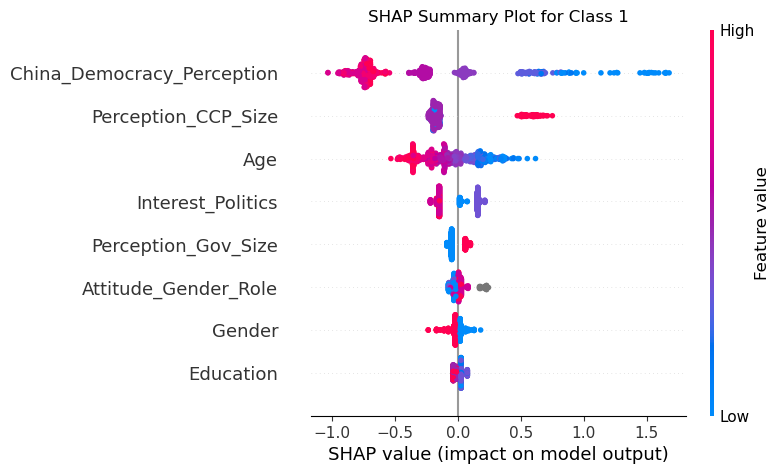

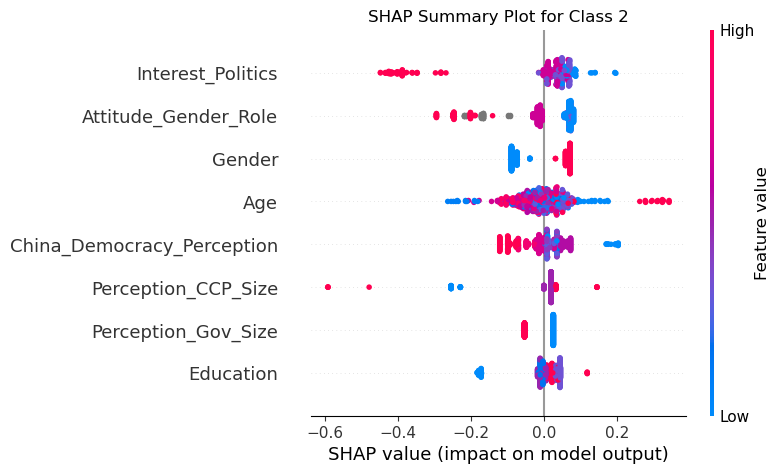

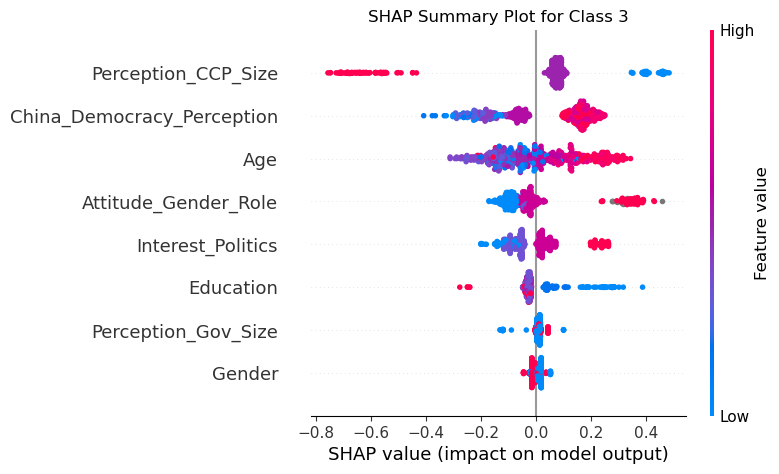

In [71]:
import shap

# Ensure your model and data are ready
# model = your trained XGBoost model
# X_test = your test dataset

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Determine the structure of shap_values

# Get the number of classes from the model
num_classes = len(model.classes_)

# Loop over all class indices and generate SHAP summary plots
for class_index in range(num_classes):

    # Correctly extract SHAP values for the desired class
    shap_values_class = shap_values[:, :, class_index]
    
    # Generate the summary plot
    shap.summary_plot(
        shap_values_class,
        X_test,
        feature_names=X_test.columns,
        show=False  # Set to False to customize the plot before showing
    )
    plt.title(f"SHAP Summary Plot for Class {model.classes_[class_index]}")
    plt.show()